# Signal vs. Bearing

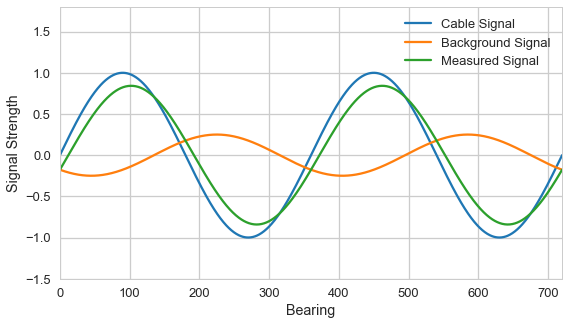

In [6]:
%matplotlib inline
import pylab as pl
import easier as ezr
x = np.linspace(0, 4 * np.pi, 1000)
xa = 180 * x / np.pi
yc = np.sin(x)
yb = .25 * np.sin(x - 3 * np.pi / 4)
ym = yc + yb

ax = ezr.figure(style='seaborn-talk', grid=True)
ax.plot(xa, yc, label='Cable Signal')
ax.plot(xa, yb, label='Background Signal')
ax.plot(xa, ym, label='Measured Signal')
ax.legend(loc='best')
ax.set_xlim(0, 720)
ax.set_ylim(-1.5, 1.8)
pl.xlabel('Bearing')
pl.ylabel('Signal Strength')

file_name = 'sigs_vs_bearing.pdf'
pl.figure(ax.figure.number)
pl.savefig(file_name)




# Generate Samples

In [7]:
from scipy.stats import gamma, bernoulli
import numpy as np


def bplus(s, m):
    return np.abs(m + s)


def bminus(s, m):
    return np.abs(m - s)


def sample_amplitude(mu: float, sigma: float, N: int):
    """
    Draw samples from a model of either the signal or the
    background amplitude distribution.
    Args:
        mu: the mean value of the amplitude model
        sigma: the standard deviation of the amplitude model
        N: the number of random points to generate
    """
    # Compute the gamma parameters that will have the desired
    # mean and standard deviation
    a = (mu / sigma) ** 2
    scale = sigma ** 2 / mu

    # Generate the random variables.
    gam = gamma(a, scale=scale)
    x = gam.rvs(size=N)
    return x
    
def sample_angle(measured, sig_mu, sig_std, back_mu, back_std, N, max_iter=100):
    x_list = []
    n_samples = N
    n_iter = 0
    while n_samples > 0 and n_iter < max_iter:
        signal = sample_amplitude(sig_mu, sig_std, n_samples)
        background = sample_amplitude(back_mu, back_std, n_samples)
        
        
        numerator = measured ** 2 + signal ** 2 - background ** 2
        denominator = 2 * measured * signal
        
        ratio = numerator / denominator
        ratio = ratio[ratio < 1]
        theta_abs = np.arccos(ratio)
        nn = len(theta_abs)
        signs = 2 * (bernoulli(.5).rvs(nn) - .5)
        theta = theta_abs * signs
        theta = theta[~np.isnan(theta)]
        x_list.extend(theta.tolist())
        n_samples = int(2 * (N - len(x_list)))
        n_iter += 1
    if n_iter >= max_iter:
        raise ValueError(
            'MaxIter encounterd.  '
            'You probably set a model that is incompatible with measurement')
    return 180 * np.array(x_list[:N]) / np.pi


# Specify the parameters
measured = 2000
sig_mu=1900
back_mu=900 
sig_std = 200
back_std = 200
N = 100000

# Generate the samples
samples = sample_angle(measured, sig_mu, sig_std, back_mu, back_std, N, max_iter=100)


# Make Sample Histogram

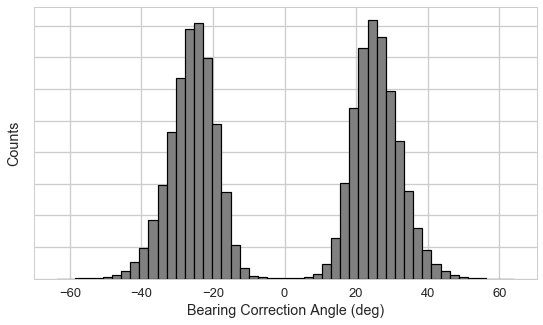

In [61]:
%matplotlib inline
import pylab as pl
import easier as ezr

ax = ezr.figure(style='seaborn-whitegrid', grid=True)
ax.hist(samples, bins=50, edgecolor='black', linewidth=1.2, color='gray')
pl.xlabel('Bearing Correction Angle (deg)')
pl.ylabel('Counts')
ax.set_yticklabels([])

file_name = 'correction_hist.pdf'
pl.figure(ax.figure.number)
pl.savefig(file_name)
_;

# Make Sample ECDF

-37.11665077714533 -28.11329642333471 28.116542987505984 37.192662263857805


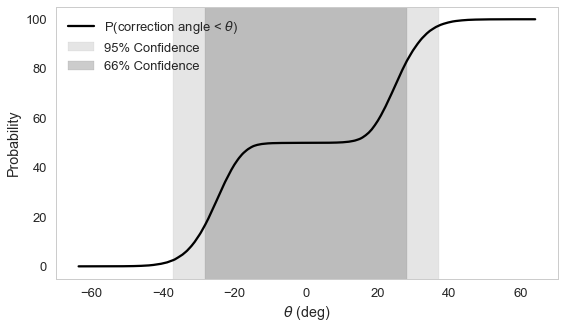

In [62]:
%matplotlib inline
import pylab as pl
import numpy as np
import easier as ezr
pl.rc('text', usetex=False)

ax = ezr.figure(style='seaborn-whitegrid', grid=False)
x, y = ezr.ecdf(samples, N=300)
xmin95, xmin66, xmax66, xmax95 = tuple(np.percentile(samples, 50 + np.array([-95/2, -66/2, 66/2, 95/2])))
print(xmin95, xmin66, xmax66, xmax95)
ymin, ymax = -20, 150
ax.plot(x, 100 *y, 'k', label=r'P(correction angle < $\theta$)')
ax.fill_between([xmin95, xmax95], [ymax, ymax], [ymin, ymin], color='grey', alpha=.2, label='95% Confidence')
ax.fill_between([xmin66, xmax66], [ymax, ymax], [ymin, ymin], color='grey', alpha=.4, label='66% Confidence')

ax.set_ylim(-5, 105)
pl.xlabel(r'$\theta$ (deg)')
# pl.ylabel(r'Prob correction angle < $\theta$')
pl.ylabel(r'Probability')

ax.legend(loc='best')

# ax.annotate('66% Confidence', xy=(-10, 95), xytext=(-65, 75),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
# ax.annotate('95% Confidence', xy=(-32, 60), xytext=(-65, 50),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )

file_name = 'correction_ecdf.pdf'
pl.figure(ax.figure.number)
pl.savefig(file_name)

_;

In [30]:
50 + np.array([-95/2, -66/2, 66/2, 95/2])

array([ 2.5, 17. , 83. , 97.5])